<a href="https://colab.research.google.com/github/BerkayYuce/football-player-market-value-prediction-model/blob/main/Reformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1️⃣ Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import math


2️⃣ Dataset ve Model Class’ları
python
Kopyala
Düzenle


In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping at counter {self.counter}")

class FootballDataset(Dataset):
    def __init__(self, X, y, seq_len=5, n_features=None):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.n_features = n_features if n_features else X.shape[1] // seq_len
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x_seq = self.X[idx].reshape(self.seq_len, self.n_features)
        y_val = self.y[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class LSHSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, bucket_size=16, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.bucket_size = bucket_size
        self.head_dim = d_model // n_heads
        self.to_qk = nn.Linear(d_model, d_model, bias=False)
        self.to_v = nn.Linear(d_model, d_model, bias=False)
        self.to_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        B, S, _ = x.shape
        QK = self.to_qk(x).view(B, S, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.to_v(x).view(B, S, self.n_heads, self.head_dim).transpose(1, 2)
        if S < self.bucket_size:
            scores = torch.matmul(QK, QK.transpose(-2, -1)) / math.sqrt(self.head_dim)
            attn = torch.softmax(scores, dim=-1)
            attn = self.dropout(attn)
            out = torch.matmul(attn, V)
        else:
            n_chunks = S // self.bucket_size
            if S % self.bucket_size != 0:
                n_chunks += 1
            outs = []
            for i in range(n_chunks):
                start = i * self.bucket_size
                end = min((i + 1) * self.bucket_size, S)
                q_chunk = QK[:, :, start:end, :]
                v_chunk = V[:, :, start:end, :]
                scores = torch.matmul(q_chunk, q_chunk.transpose(-2, -1)) / math.sqrt(self.head_dim)
                attn = torch.softmax(scores, dim=-1)
                attn = self.dropout(attn)
                chunk_out = torch.matmul(attn, v_chunk)
                outs.append(chunk_out)
            out = torch.cat(outs, dim=2)
        out = out.transpose(1,2).contiguous().view(B, S, self.d_model)
        return self.to_out(out)

class ReversibleBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attn = LSHSelfAttention(d_model // 2, n_heads, dropout=dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model // 2, (d_model // 2) * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear((d_model // 2) * 4, d_model // 2)
        )
        self.norm1 = nn.LayerNorm(d_model // 2)
        self.norm2 = nn.LayerNorm(d_model // 2)
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=-1)
        y1 = x1 + self.attn(self.norm1(x2))
        y2 = x2 + self.ff(self.norm2(y1))
        return torch.cat([y1, y2], dim=-1)

class Reformer(nn.Module):
    def __init__(self, seq_len, n_features, d_model=128, n_heads=4, n_layers=6, bucket_size=16, dropout=0.1, out_dim=1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = SinusoidalPositionalEncoding(d_model, max_len=seq_len)
        self.blocks = nn.ModuleList([
            ReversibleBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, out_dim)
        )
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        if x.shape[-1] % 2 != 0:
            x = F.pad(x, (0,1))
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        x = x.transpose(1,2)
        x = self.global_pool(x).squeeze(-1)
        out = self.fc(x).squeeze(-1)
        return out

def safe_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100


3️⃣ Dosya Yükleme ve DataLoader Hazırlığı

In [ ]:
# CSV dosyalarını yükle
train = pd.read_csv('/content/train.csv')
val = pd.read_csv('/content/val.csv')
test = pd.read_csv('/content/test.csv')

target_col = "target"
id_cols = ["Oyuncu_ID", "Date"]
seq_len = 5

feature_cols = [col for col in train.columns if col not in [target_col] + id_cols]
feature_sets = [
    set([col.replace(f"_t{i}", "") for col in feature_cols if col.endswith(f"_t{i}")])
    for i in range(1, seq_len + 1)
]
common_features = set.intersection(*feature_sets)
print(f"Her sezon ortak feature sayısı: {len(common_features)}")

ordered_cols = []
for i in range(1, seq_len + 1):
    ordered_cols += [f"{feat}_t{i}" for feat in sorted(common_features)]

def prepare_X_y(df):
    X = df[ordered_cols].values
    y = df[target_col].values
    return X, y

X_train, y_train = prepare_X_y(train)
X_val, y_val = prepare_X_y(val)
X_test, y_test = prepare_X_y(test)

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

dataset_train = FootballDataset(X_train_scaled, y_train_scaled, seq_len=seq_len, n_features=len(common_features))
dataset_val   = FootballDataset(X_val_scaled,   y_val_scaled,   seq_len=seq_len, n_features=len(common_features))
dataset_test  = FootballDataset(X_test_scaled,  y_test_scaled,  seq_len=seq_len, n_features=len(common_features))
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


Her sezon ortak feature sayısı: 53


4️⃣ Model Kurulumu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = Reformer(
    seq_len=seq_len,
    n_features=len(common_features),
    d_model=128,
    n_heads=4,
    n_layers=3,
    bucket_size=16,
    dropout=0.3,
    out_dim=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.MSELoss()

Using device: cpu


5️⃣ Eğitim & Değerlendirme

In [ ]:
train_losses, val_losses = [], []
early_stopping = EarlyStopping(patience=10, min_delta=0.001)
start_train = time.time()
best_val_loss = float('inf')

print("REFORMER TRAINING BAŞLADI")
for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    model.eval()
    total_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total_val += loss.item()
    val_loss = total_val / len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    early_stopping(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_reformer_model.pth')
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {current_lr:.2e}")
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
end_train = time.time()
train_time = end_train - start_train

model.load_state_dict(torch.load('best_reformer_model.pth'))

start_inf = time.time()
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())
end_inf = time.time()
inf_time = end_inf - start_inf

y_true_inv = scaler_y.inverse_transform(np.array(y_true).reshape(-1,1)).flatten()
y_pred_inv = scaler_y.inverse_transform(np.array(y_pred).reshape(-1,1)).flatten()

mse = mean_squared_error(y_true_inv, y_pred_inv)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)
mape = safe_mape(y_true_inv, y_pred_inv)

print("\n" + "="*50)
print("🔥 REFORMER FINAL RESULTS 🔥")
print("="*50)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Inference Time: {inf_time:.4f} seconds")
print("="*50)


🔥 REFORMER TRAINING BAŞLADI 🔥
Epoch   1 | Train: 0.7876 | Val: 0.5117 | LR: 1.00e-04
Epoch   2 | Train: 0.4651 | Val: 0.3678 | LR: 1.00e-04
Epoch   3 | Train: 0.3454 | Val: 0.3052 | LR: 1.00e-04
Epoch   4 | Train: 0.3066 | Val: 0.2834 | LR: 1.00e-04
Epoch   5 | Train: 0.2771 | Val: 0.2963 | LR: 1.00e-04
Epoch   6 | Train: 0.2552 | Val: 0.2570 | LR: 1.00e-04
Epoch   7 | Train: 0.2437 | Val: 0.2391 | LR: 1.00e-04
Epoch   8 | Train: 0.2334 | Val: 0.2345 | LR: 1.00e-04
Epoch   9 | Train: 0.2218 | Val: 0.2243 | LR: 1.00e-04
Epoch  10 | Train: 0.2083 | Val: 0.2452 | LR: 1.00e-04
Epoch  11 | Train: 0.2032 | Val: 0.2111 | LR: 1.00e-04
Epoch  12 | Train: 0.1900 | Val: 0.2191 | LR: 1.00e-04
Epoch  13 | Train: 0.1898 | Val: 0.2144 | LR: 1.00e-04
Epoch  14 | Train: 0.1771 | Val: 0.2311 | LR: 1.00e-04
Epoch  15 | Train: 0.1771 | Val: 0.2040 | LR: 1.00e-04
Epoch  16 | Train: 0.1785 | Val: 0.2324 | LR: 1.00e-04
Epoch  17 | Train: 0.1639 | Val: 0.2323 | LR: 1.00e-04
Epoch  18 | Train: 0.1621 | Val: 0.

6️⃣ Grafikler

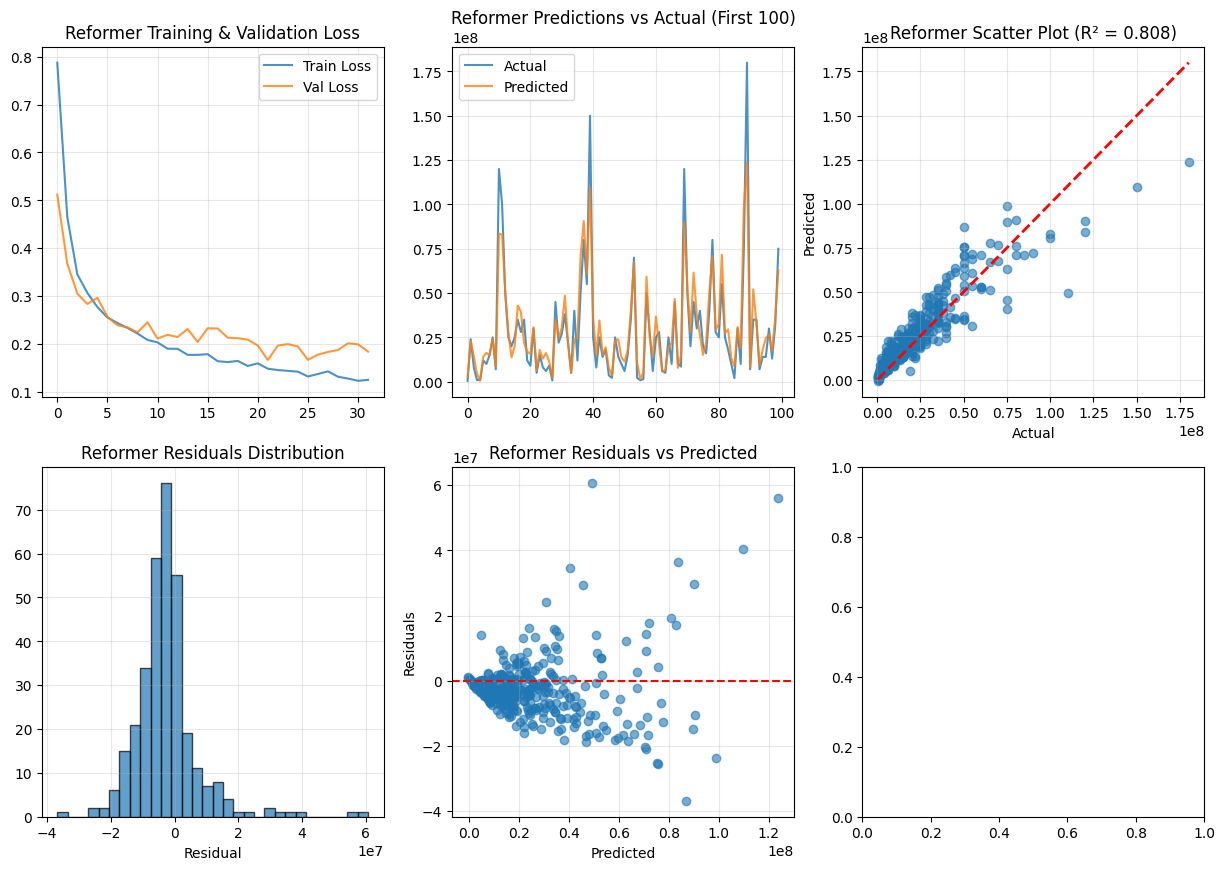

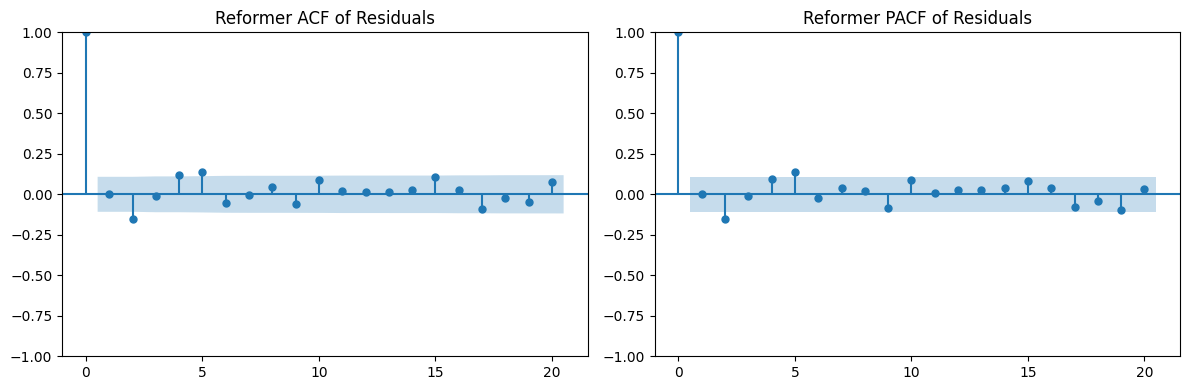

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0,0].plot(train_losses, label='Train Loss', alpha=0.8)
axes[0,0].plot(val_losses, label='Val Loss', alpha=0.8)
axes[0,0].set_title('Reformer Training & Validation Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(y_true_inv[:100], label='Actual', alpha=0.8)
axes[0,1].plot(y_pred_inv[:100], label='Predicted', alpha=0.8)
axes[0,1].set_title('Reformer Predictions vs Actual (First 100)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[0,2].scatter(y_true_inv, y_pred_inv, alpha=0.6)
axes[0,2].plot([y_true_inv.min(), y_true_inv.max()], [y_true_inv.min(), y_true_inv.max()], 'r--', lw=2)
axes[0,2].set_xlabel('Actual')
axes[0,2].set_ylabel('Predicted')
axes[0,2].set_title(f'Reformer Scatter Plot (R² = {r2:.3f})')
axes[0,2].grid(True, alpha=0.3)

residuals = y_true_inv - y_pred_inv
axes[1,0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Reformer Residuals Distribution')
axes[1,0].set_xlabel('Residual')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(y_pred_inv, residuals, alpha=0.6)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Reformer Residuals vs Predicted')
axes[1,1].grid(True, alpha=0.3)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, lags=20, ax=ax1)
plot_pacf(residuals, lags=20, ax=ax2)
ax1.set_title("Reformer ACF of Residuals")
ax2.set_title("Reformer PACF of Residuals")
plt.tight_layout()
plt.show()
